# Pylops - Least squares image-domain migration - marmousi model

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` operator to perform image-domain least-squares migration using data from FD modelling.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import devito

from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway    import AcousticWave2D

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

from examples.seismic import Model
from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Receiver
from examples.seismic import plot_velocity, plot_shotrecord

devito.configuration['log-level'] = 'ERROR'

## Model and data creation

Lets' create a model and geometry

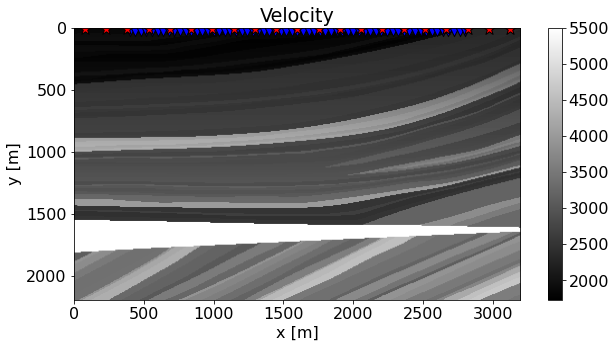

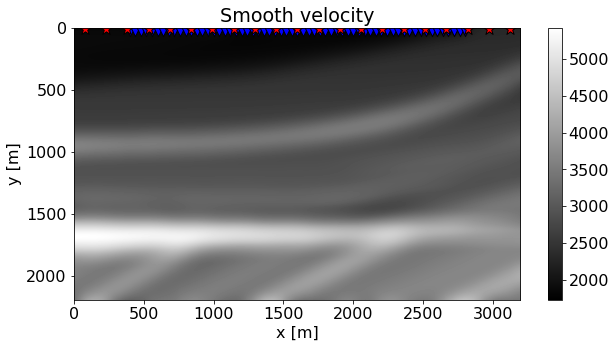

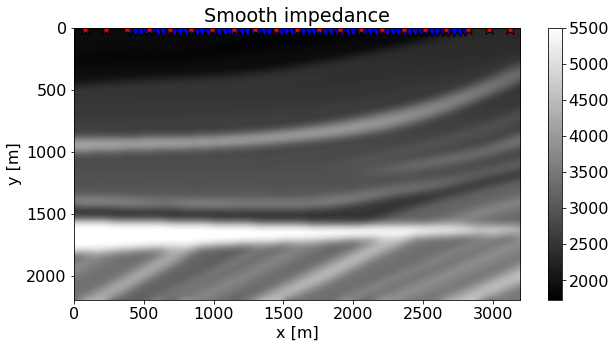

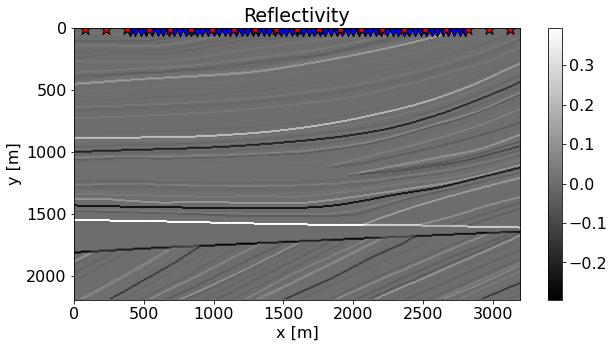

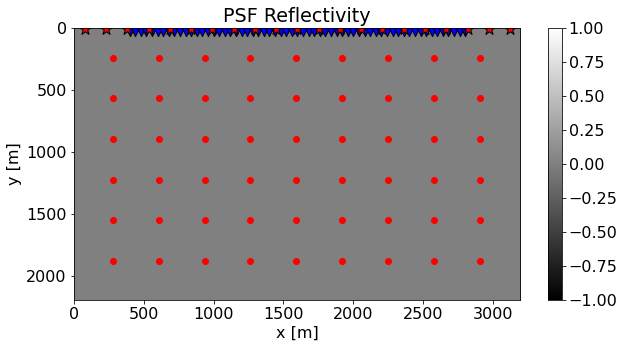

In [2]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], vel_true[::2, ::2]
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(nx, nz), axis=1)
refl = Dop * np.log(ip_true)

# PSF Model
psfrefl = np.zeros((nx, nz))
psfin = (35, 30)
psfend = (-34, -20)
psfj = (41, 41)
psfsize = (31, 31)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

# PSF grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

# Smooth velocity
nsmooth = 20
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

# Smooth impedance
nsmooth = 10
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_true, axis=0)
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_sm, axis=1)

# Receivers
nr = 61
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 21
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(ip_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth impedance')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(Psfx.ravel()*dx, Psfz.ravel()*dz, c='r')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

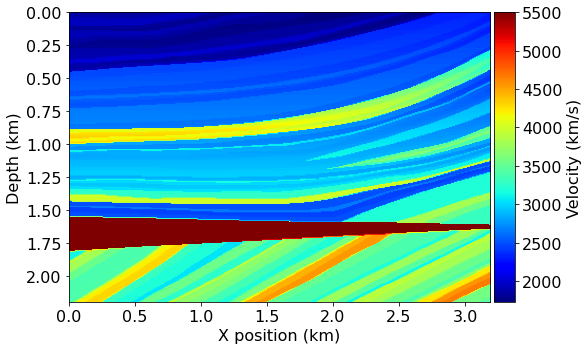

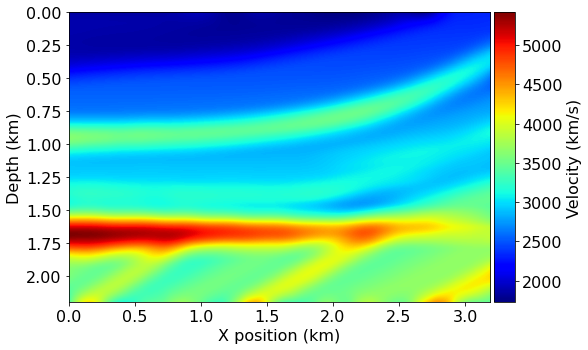

In [3]:
# modelling params
nbl = 100 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 20 # Source peak frequency
tn = 3000 # Total simulation time

model = Model(space_order=space_order, vp=vel_true, origin=(0, 0), shape=(nx, nz),
              dtype=np.float32, spacing=(dx, dz), nbl=nbl, bcs="damp")

smooth_model = Model(space_order=space_order, vp=vel_sm, origin=(0, 0), shape=(nx, nz),
                     dtype=np.float32, spacing=(dx, dz), nbl=nbl, bcs="damp")

plot_velocity(model)
plot_velocity(smooth_model)

In [4]:
Aop = AcousticWave2D((nx, nz), (0, 0), (dx, dz), vel_true,
                     sx, sz, rx, rz, 0., tn, 'Ricker',
                     space_order=space_order, nbl=nbl, f0=f0,
                     dtype="float32", name="A")

In [5]:
nt = Aop.geometry.nt
dt = Aop.geometry.dt / 1e3
data = np.zeros((ns, nr, nt))

for isrc in range(ns):
    geometry = AcquisitionGeometry(
                Aop.model,
                Aop.geometry.rec_positions,
                Aop.geometry.src_positions[isrc, :],
                Aop.geometry.t0,
                Aop.geometry.tn,
                f0=Aop.geometry.f0,
                src_type=Aop.geometry.src_type)
    
    # model
    solver = AcousticWaveSolver(Aop.model, geometry, space_order=Aop.space_order)
    d = solver.forward()[0]
    d = d.resample(geometry.dt).data[:][: geometry.nt].T
    data[isrc] = d
    
# Remove wavelet
wcenter = np.argmax(geometry.src.data)
data = np.pad(data[..., wcenter:], ((0, 0), (0, 0), (0, wcenter)))

# Subsample
data = data[..., ::4]
nt = data.shape[-1]
dt *= 4
t = np.arange(nt) * dt

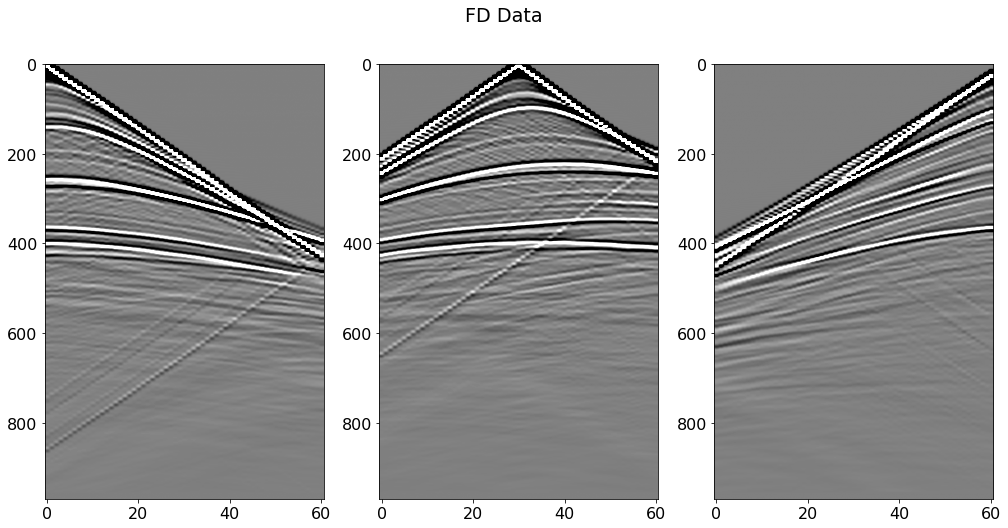

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(17, 8))
fig.suptitle('FD Data')
axs[0].imshow(data[2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axis('tight')
axs[1].imshow(data[ns//2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axis('tight')
axs[2].imshow(data[-2, :, :].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[2].axis('tight');

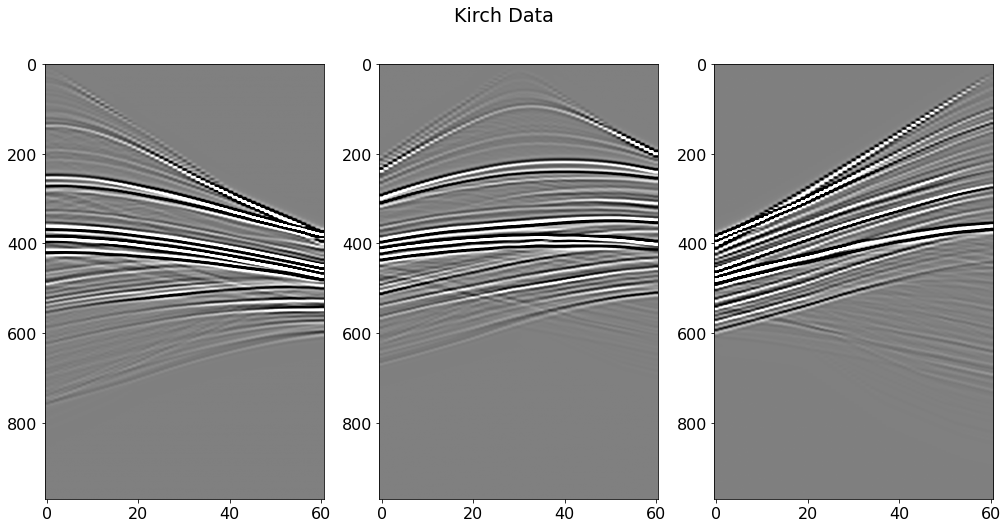

In [7]:
wav, _, wavc = ricker(t[:41], f0=f0)

kop = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                dynamic=False, wavfilter=True, engine='numba')
dkirch = kop * refl.ravel()
dkirch = dkirch.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(17, 8))
fig.suptitle('Kirch Data')
axs[0].imshow(dkirch[2, :, :].T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[0].axis('tight')
axs[1].imshow(dkirch[ns//2, :, :].T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[1].axis('tight')
axs[2].imshow(dkirch[-2, :, :].T, cmap='gray', vmin=-1e3, vmax=1e3)
axs[2].axis('tight');

### Migration

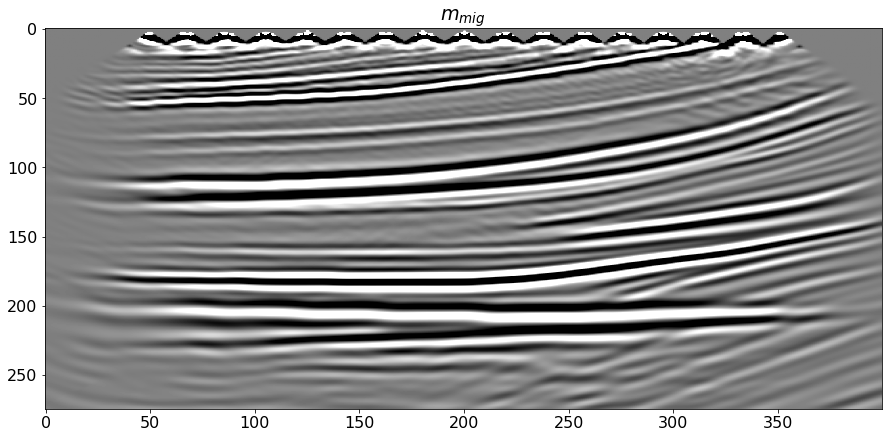

In [8]:
kopdyn = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

mmig = kopdyn.H * data.ravel()
mmig = mmig.reshape(nx, nz)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.imshow(mmig.T, cmap='gray', vmin=-1e-3, vmax=1e-3)
ax.set_title(r'$m_{mig}$')
ax.axis('tight');

### PSF creation and migration

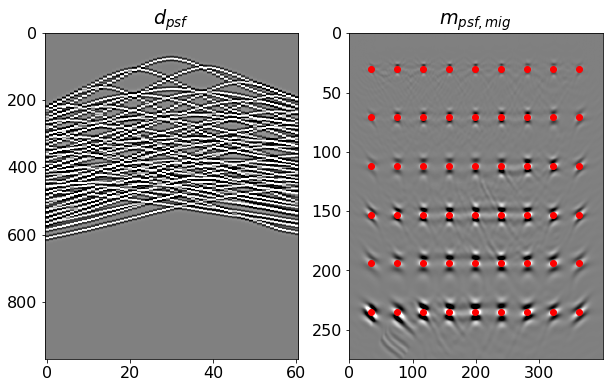

In [9]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-1e2, vmax=1e2, interpolation='none')
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-4, vmax=4)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

## Image domain LSM

First, we extract the different PSFs

In [10]:
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

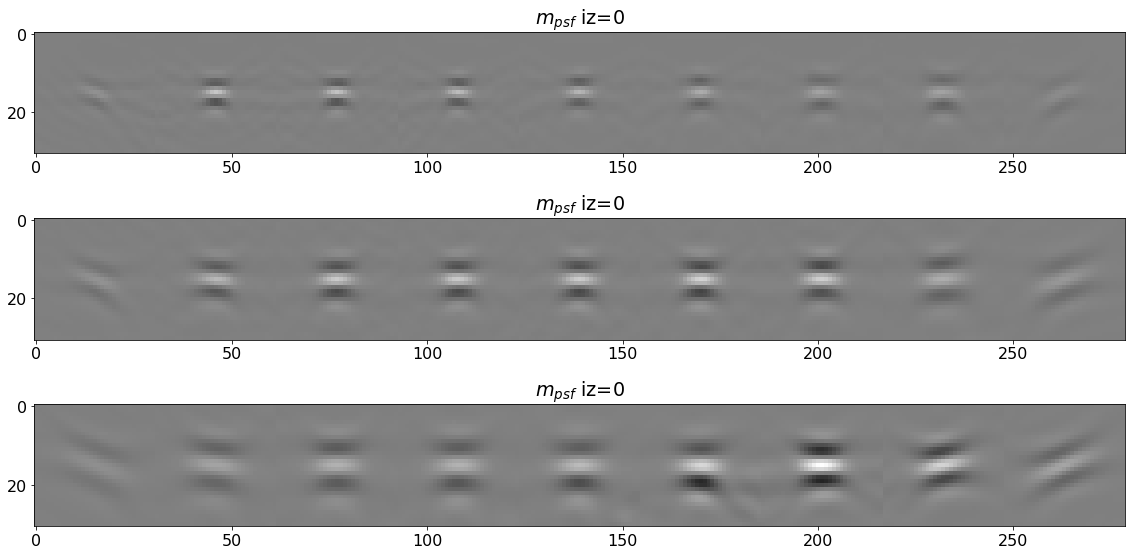

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{psf}$ iz=0')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'$m_{psf}$ iz=0')
axs[2].axis('tight')
plt.tight_layout()

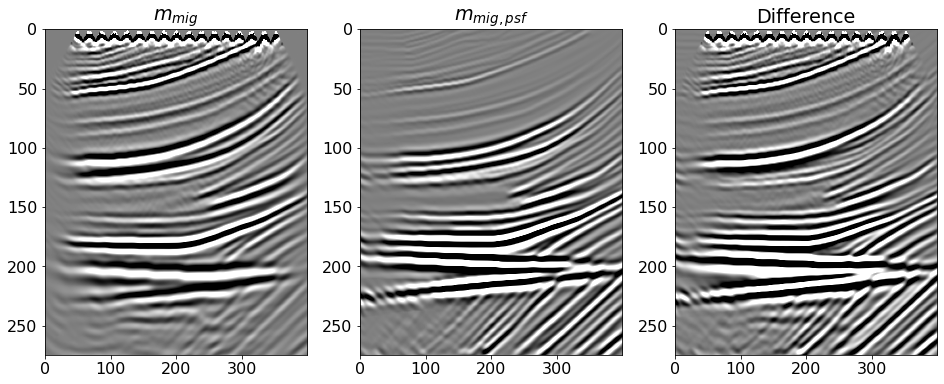

In [12]:
mmig *= 1e4
Cop = NonStationaryConvolve2D(hs=psfs, ihx=psfx, ihz=psfz, dims=(nx, nz), engine="numba")

mmigpsf = Cop * refl.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'Difference')
axs[2].axis('tight');

In [13]:
dottest(Cop, verb=True, raiseerror=False);

Dot test passed, v^H(Opu)=12893.77844894346 - u^H(Op^Hv)=12893.778448943467


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
eps = 4.000000e+01	tol = 1.000000e-10	niter = 200
alpha = 8.586342e-07	thresh = 1.717268e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         1.485e+07   1.486e+07   8.238e-01
     2      -0.0000e+00         1.447e+07   1.448e+07   6.001e-01
     3      -0.0000e+00         1.416e+07   1.417e+07   6.197e-01
     4      -0.0000e+00         1.390e+07   1.392e+07   6.221e-01
     5      -0.0000e+00         1.367e+07   1.370e+07   6.229e-01
     6      -0.0000e+00         1.348e+07   1.350e+07   6.288e-01
     7      -0.0000e+00         1.329e+07   1.332e+07   6.408e-01
     8      -0.0000e+00         1.312e+07   1.315e+07   6.580e-01
     9      -0.0000e+00         1.295e+07   1.299e+07   6.788e-01
    10      

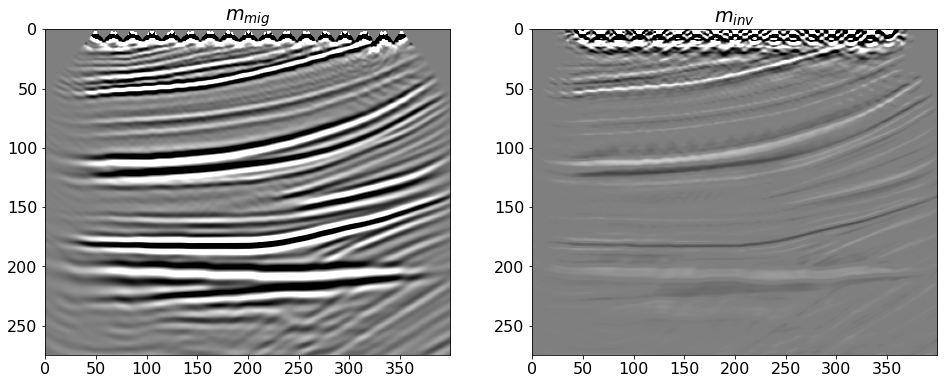

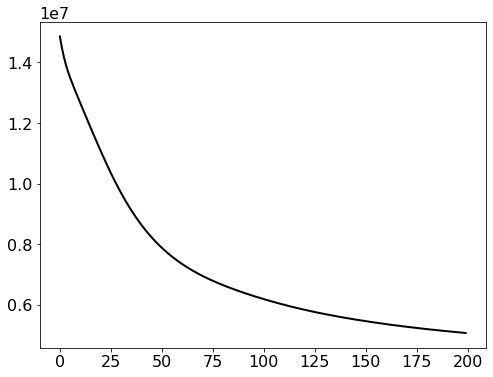

In [14]:
reflinv, _, resnorm = fista(Cop, mmig.ravel(), eps=4e1, niter=200, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = reflinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

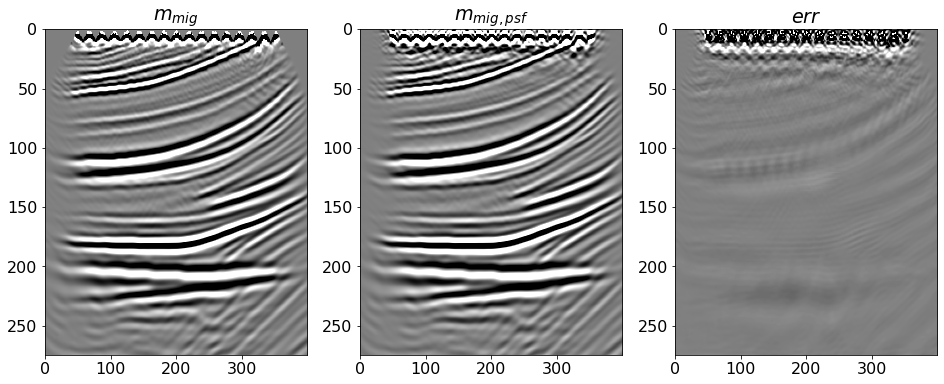

In [15]:
dinv = Cop @ reflinv.ravel()
dinv = dinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

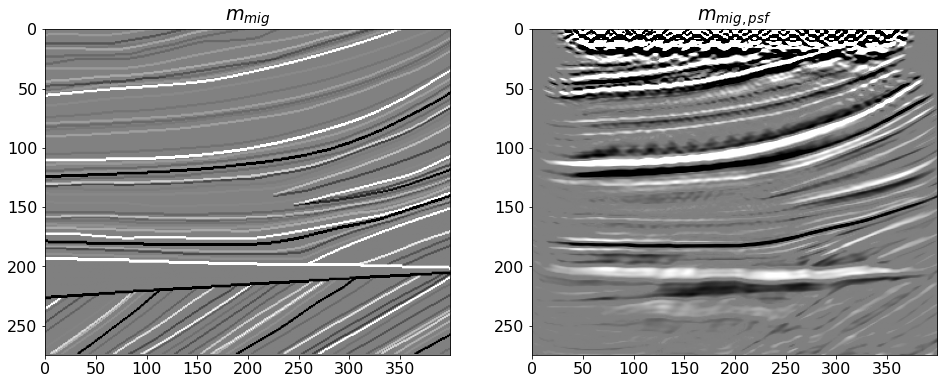

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(refl.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');

## Image domain LSM for impedance

In [17]:
# Impedance LSM operator
LSMop = Cop * Dop

# Regularized inversion
Regop = Laplacian(dims=(nx, nz))
ip_inv = regularized_inversion(LSMop, mmig.ravel(), [Regop], 
                               x0=np.log(ip_sm).ravel(),
                               epsRs=[1e1], **dict(iter_lim=50, show=True))[0]
ip_inv = np.exp(ip_inv).reshape(nx, nz)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
Regs=[<110000x110000 LinearOperator with dtype=float64>]
epsRs=[10.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 220000 rows and 110000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.581e+03  5.581e+03    1.0e+00  1.8e-02
     1  2.95006e-06   5.334e+03  5.334e+03    9.6e-01  2.2e-01   3.3e+02  1.0e+00
     2  8.00635e-06   5.187e+03  5.187e+03    9.3e-01  1.5e-01   5.2e+02  2.5e+00
     3  1.62086e-05   5.036e+03  5.036e+03    9.0e-01  1.1e-01   6.9e+02  4.8e+00
     4  2.77180e-05   4.880e+03  4.880e+03    8.7e-01  1.0e-01   8.2e+02  7.5e+00
     

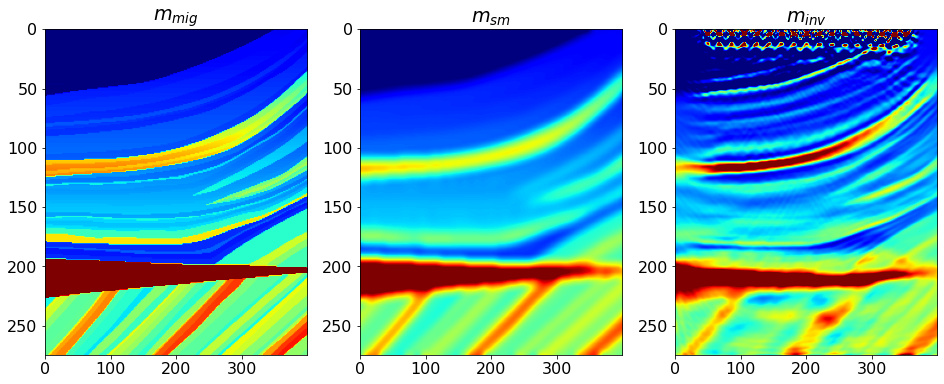

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_inv.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{inv}$')
axs[2].axis('tight');

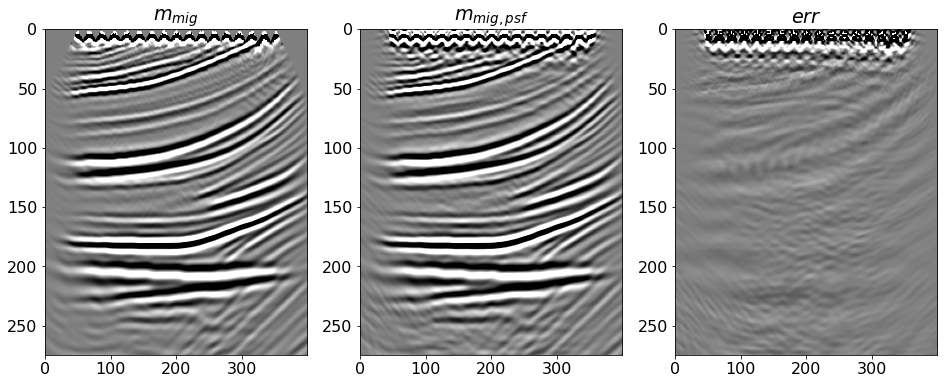

In [19]:
minv = LSMop @ np.log(ip_inv)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(minv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-minv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

In [20]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 1e0
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=LSMop, b=mmig.ravel(), x0=np.log(ip_sm).ravel(), niter=10, warm=True, sigma=0.001)
Gop = Gradient(dims=(nx, nz), edge=True, dtype=LSMop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

ip_pd = PrimalDual(l2, l1, Gop, np.log(ip_sm).ravel(), tau=tau, mu=mu, 
                    theta=1., niter=100, show=True)
ip_pd = np.exp(ip_pd).reshape(nx,nz)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 1.0		mu = 0.12375
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.52294e+00   1.408e+04   1.516e+03   0.000e+00       1.560e+04
     2   7.52294e+00   1.355e+04   1.752e+03   0.000e+00       1.531e+04
     3   7.52295e+00   1.325e+04   1.882e+03   0.000e+00       1.513e+04
     4   7.52295e+00   1.301e+04   2.007e+03   0.000e+00       1.501e+04
     5   7.52296e+00   1.281e+04   2.118e+03   0.000e+00       1.492e+04
     6   7.52296e+00   1.263e+04   2.208e+03   0.000e+00       1.484e+04
     7   7.52297e+00   1.247e+04   2.302e+03   0.000e+00       1.477e+04
     8   7.52297e+00   1.233e+04   2.373e+03   0.

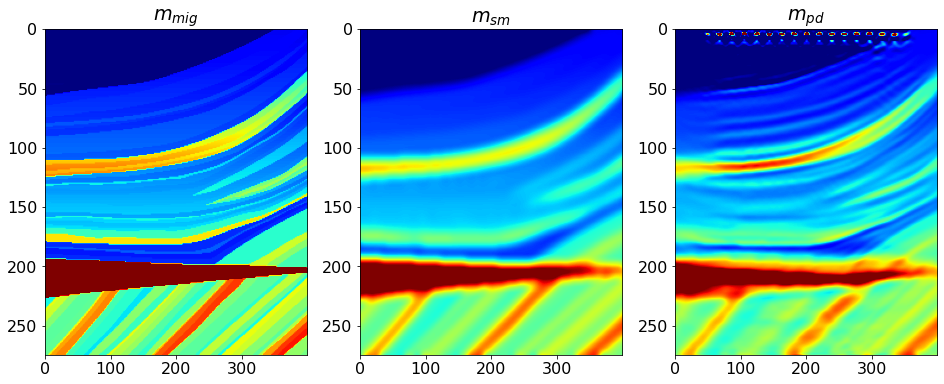

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(ip_true.T, cmap='jet', vmin=2000, vmax=5000)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(ip_sm.T, cmap='jet', vmin=2000, vmax=5000)
axs[1].set_title(r'$m_{sm}$')
axs[1].axis('tight')
axs[2].imshow(ip_pd.T, cmap='jet', vmin=2000, vmax=5000)
axs[2].set_title(r'$m_{pd}$')
axs[2].axis('tight');

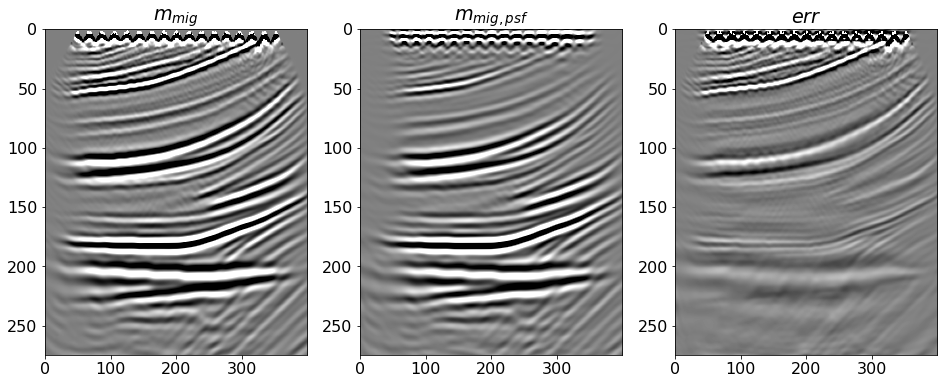

In [22]:
mpd = LSMop @ np.log(ip_pd)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-mpd.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');